In [ ]:
%matplotlib inline
#import matplotlib; matplotlib.use('Agg')

#cache files
#ls | parallel -L50 "vmtouch -t {}"


import os
from os.path import isdir, join, basename, dirname
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import warnings
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="scipy.io")

from sklearn import model_selection

from tqdm import tqdm_notebook
import wave
import speechpy
import seaborn as sns
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from sklearn import model_selection
from matplotlib import pyplot as plt
plt.switch_backend('agg')

import gc
import datetime
import sys

from utils import logger, send2telegramm

##### SETTINGS:

In [ ]:
#ACTIONS:
DO_TRAIN = True
DO_CUSTOM_PREDICT = False
MODEL_PATH_CUSTOM_PREDICT = 'saved_models/cnn_gpu_1' # in case if DO_CUSTOM_PREDICT == True
DEBAG = False
PRECEED_TRAIN = 'NO'  # YES - upload pretrained model
                       # NO -  start new train


NUM_FILTERS_CONV_1 = 32  #32
NUM_FILTERS_CONV_2 = 64
NUM_FILTERS_CONV_3 = 128
NUM_READOUT_NEURONS = 1024 #1024

KEEP_PROB = 0.99
LEARNING_RATE = 1.0e-5   #1.0e-5
TEST_SIZE = 0.03     #0.0002
BATCH_SIZE = 100
N_CLASSES = 30
NUM_EPOCHS = 300
NUMBER_STEPS = int(64721*NUM_EPOCHS/BATCH_SIZE)
if DEBAG:
    NUMBER_STEPS = 100

preprocessed_version = 'v1'  #if the files of the version are exist, we will not to preprocess them

thersold_good_prediction = 0.99999999
NUMBER_STEPS_TEST = int(NUMBER_STEPS/2) #bymber of step in 
AFTER_NUM_STEPS_APPEND_TEST_DATA = int(NUMBER_STEPS/4) #every the number append test date to train

date = datetime.date.today().isoformat()
model_dir = 'cnn_gpu_2'
model_path = join('saved_models', '{}/model_{}'.format(model_dir, date))


    
    
if PRECEED_TRAIN == 'YES':
    saved_model_dir = ''
    logger.info('I will upload pretrained model from: {}'.format(saved_model_dir))
    if not os.path.exists(saved_model_dir):
        sys.exit("the prelimenary trained model path doesn't exist")
logger.info('model_path: {}'.format(model_path))

logger.info("NUM_FILTERS_CONV_1 = {}".format(NUM_FILTERS_CONV_1))
logger.info("NUM_FILTERS_CONV_2 = {}".format(NUM_FILTERS_CONV_2))
logger.info("NUM_FILTERS_CONV_3 = {}".format(NUM_FILTERS_CONV_3))
logger.info("NUM_READOUT_NEURONS = {}".format(NUM_READOUT_NEURONS))
logger.info("KEEP_PROB = {}".format(KEEP_PROB))
logger.info("LEARNING_RATE = {}".format(LEARNING_RATE))
logger.info("TEST_SIZE = {}".format(TEST_SIZE))
logger.info("NUM_EPOCHS = {}".format(NUM_EPOCHS))
logger.info("NUMBER_STEPS = {}".format(NUMBER_STEPS))
logger.info("BATCH_SIZE = {}".format(BATCH_SIZE))
logger.info("N_CLASSES = {}".format(N_CLASSES))
logger.info("thersold_good_prediction = {}".format(thersold_good_prediction))
logger.info("NUMBER_STEPS_TEST = {}".format(NUMBER_STEPS_TEST))
logger.info("AFTER_NUM_STEPS_APPEND_TEST_DATA = {}".format(AFTER_NUM_STEPS_APPEND_TEST_DATA))

##### PREPROCESSING

In [ ]:
def get_sample_rate(path):
    sample_rate, samples = wavfile.read(path)
    return sample_rate

def get_amplitudes(path):
    sample_rate, samples = wavfile.read(path)
    return samples

def remove_silence_start():
    pass

def complete_by_const(array, const = 0, req_len = 16000):
    if len(array) < req_len:
        new = np.array([const]*req_len)
        new[:len(array)] = array
    elif len(array) > req_len:
        new = array[:req_len]
    else:
        new = array
    return new

def encodeTarget(y):
    temp = np.zeros((y.size, y.max()+1))
    temp[np.arange(y.size), y] = 1
    return temp.astype(int)

def preprocess_dataframe(df, process_target = True):
    global map_dict, map_dict_reverse
    df['sample_rate'] = df.train_names.apply(lambda x: get_sample_rate(x))
    df['amplitudes'] = df.train_names.apply(lambda x: get_amplitudes(x))
    df['avg_ampl'] = df.amplitudes.apply(lambda x: x.mean())
    df['std_ampl'] = df.amplitudes.apply(lambda x: x.std())
    df['len'] = df.amplitudes.apply(lambda x: len(x))
    df['amplitudes'] = df.amplitudes.apply(lambda x: complete_by_const(x))
    df['len'] = df.amplitudes.apply(lambda x: len(x))  
    if process_target:
        uniq_labels = sorted(df.train_labels.unique().tolist())
        map_dict = dict(zip(uniq_labels, range(len(uniq_labels))))   # label -> digit
        map_dict_reverse = dict((b,a) for a,b in map_dict.items())   # digit -> label
        df['encod_label'] = df.train_labels.apply(lambda x : map_dict[x])
    return df    
      
WORKDIR = '/home/dkuzin/files/tensorflow_speech_recognition'

train_audio_path = WORKDIR + '/train/audio/'
test_audio_path = WORKDIR + '/test/audio/'
to_keep = 'yes no up down left right on off stop go silence unknown'.split()    
    
    
path_df_train = 'saved_variables/{}_df_train.pkl'.format(preprocessed_version)
path_df_predict = 'saved_variables/{}_df_predict.pkl'.format(preprocessed_version)

if (os.path.exists(path_df_train) and os.path.exists(path_df_predict)):
    logger.info("the data are preprossesed yet, uploading it")
    df_train = pd.read_pickle(path_df_train)
    uniq_labels = sorted(df_train.train_labels.unique().tolist())
    map_dict = dict(zip(uniq_labels, range(len(uniq_labels))))   # label -> digit
    map_dict_reverse = dict((b,a) for a,b in map_dict.items())   # digit -> label
    df_predict = pd.read_pickle(path_df_predict)
else:    
    #read and process train part:
    logger.info("start to preprocess data")
    dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
    dirs.sort()

    train_names = []
    for directory in dirs:
        directory = join(train_audio_path, directory)
        files = [join(directory,f) for f in os.listdir(directory) if f.endswith('.wav')]
        train_names.extend(files)
    train_names.sort()
    train_labels = [f.split('/')[-2] for f in train_names]
    user_names = [basename(f).split("_")[0] for f in train_names]
    df_train = pd.DataFrame({'train_names':train_names,
                       'train_labels':train_labels,
                       'user_names':user_names})
    df_train = df_train[['train_names', 'user_names','train_labels']]
    df_train = df_train[df_train.train_labels != '_background_noise_']
    df_train = preprocess_dataframe(df_train, process_target = True)

    #read and process predict part:
    test_names = [join(test_audio_path, f) for f in os.listdir(test_audio_path) 
                              if f.endswith('.wav')]
    user_names = [basename(f) for f in test_names]
    df_predict = pd.DataFrame({'train_names':test_names, 'user_names':user_names})
    df_predict = preprocess_dataframe(df_predict, process_target = False)
    
    df_train.to_pickle(path_df_train)
    df_predict.to_pickle(path_df_predict)

X = np.vstack(df_train.amplitudes.values)
y = df_train.encod_label.values
y_binary = encodeTarget(y)

X_predict = np.vstack(df_predict.amplitudes.values)

logger.info("y_binary.shape of train data = {}".format(y_binary.shape))
logger.info("X.shape of train data = {}".format(X.shape))
logger.info("X_predict.shape of predict data = {}".format(X_predict.shape))

In [ ]:
if DEBAG:
#decrease number of elements in training (DELETE IT, for debug only)
    X, y, y_binary, df_short = X[::100], y[::100], y_binary[::100], df[::100]
    X_predict = X_predict[:10000]

In [ ]:
def func(signal):
    return speechpy.feature.lmfe(signal, 16000, frame_length=0.02, 
                frame_stride=0.01, num_filters=40, fft_length=512, low_frequency=0, 
                high_frequency=None)

path_proc_train = 'saved_variables/{}_proc_train.npy'.format(preprocessed_version)
path_proc_predict = 'saved_variables/{}_proc_predict.npy'.format(preprocessed_version)

if (os.path.exists(path_proc_train) and os.path.exists(path_proc_predict)):
    logger.info("the PROC data are preprossesed yet, uploading it")
    proc_train = np.load(path_proc_train)
    x_test_to_submit = np.load(path_proc_predict)
else: 
    logger.info("start to PROC preprocess data")
    t = time.time()
    proc_train = np.apply_along_axis(func, 1,X)
    logger.info("train was transformed, elapsed time is {:.4f} sec".format(time.time()-t))
    t = time.time()
    x_test_to_submit = np.apply_along_axis(func, 1, X_predict)
    logger.info("predict data was transformed, elapsed time is {:.4f} sec".format(time.time()-t))
    
    np.save(path_proc_train, proc_train)
    np.save(path_proc_predict, x_test_to_submit)

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
                        proc_train, y_binary, test_size = TEST_SIZE)

_ = gc.collect()
logger.info("shapes = X_train {}, y_train {}, X_valid {}, y_valid {}".format(
        X_train.shape, y_train.shape, X_valid.shape, y_valid.shape))

### CNN MODEL

In [ ]:
def next_batch(batch_size):
    global data_index
    batch = X_train[data_index:data_index+batch_size,:]
    labels = y_train[data_index:data_index+batch_size]
    data_index = (data_index + batch_size) % (X_train.shape[0])
    return (batch, labels)

def next_batch_from_test(batch_size, X_add , y_add):
    #get next batch
    global data_index_test
    batch = X_add[data_index_test:data_index_test+batch_size,:]
    labels = y_add[data_index_test:data_index_test+batch_size,:]
    data_index_test = (data_index_test + batch_size) % (X_add.shape[0])
    return (batch, labels)

def mark_test_data_and_extract_well_predicted():
    #idea:
    #if prelimenary trained algo show very high probability a element belong to the class, 
    # we'll append it to training sample and retrain the algo
    logger.info("x_test_to_submit.shape = {}".format(x_test_to_submit.shape))
    size = 100
    batches_generator = (x_test_to_submit[i:i + size] for i in range(0, len(x_test_to_submit), size))
    predictions = []
       
    for test_batch in batches_generator:
        predicted = y_conv.eval(session=sess, feed_dict={x:test_batch, keep_prob: 1.0})
        predictions.extend(predicted)
    temp_session = tf.Session()
    predictions = np.array(predictions)           # to numpy array
    predictions = tf.nn.softmax(predictions).eval(session=temp_session)
    
    predictions = (predictions >= thersold_good_prediction).astype(int) #transform to [0,0,0,1,0,0,]
                                                                       #if there is no outstanding value,
                                                                       #predicted will consist of zeros
    bool_values = np.any(predictions, axis = 1)   # True means there is non-zero element
                                                  # False means all elements equal zeros
    indexes = np.argwhere(bool_values).ravel()     # indexes of "True"
    temp_session.close()
    return x_test_to_submit[indexes], predictions[indexes]          


graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 99, 40])  #features
    y_ = tf.placeholder(tf.float32, shape=[None, N_CLASSES])  #true targets
    
    # weight inotialization
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, mean=0.0, stddev=0.1)   #init by random values ~N(0.0,0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)   #init by constant
        return tf.Variable(initial)

   # First Convolutional Layer  # 5,5
    W_conv1 = weight_variable([20, 20, 1, NUM_FILTERS_CONV_1])     #32 maps, tune
    b_conv1 = bias_variable([NUM_FILTERS_CONV_1])

    x_image = tf.reshape(x, [-1,99,40,1])
    #-1 - is the special value, the size of that dimension is computed so that the total size remains constant
    #28,28 - width and height
    #1 - RGB numbers (we have black and white pics, therefore we have only 1 number)

    #convolution layer, activation function and pooling layer
    h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')
    h_relu1 = tf.nn.relu(h_conv1 + b_conv1)
    h_pool1 = tf.nn.max_pool(h_relu1, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME') #99*40 --> 50*20 
    
    # second convolutional layer
                               #5,5
    W_conv2 = weight_variable([10, 10, NUM_FILTERS_CONV_1, NUM_FILTERS_CONV_2])
    b_conv2 = bias_variable([NUM_FILTERS_CONV_2])

    h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')
    h_relu2 = tf.nn.relu(h_conv2 + b_conv2)
    h_pool2 = tf.nn.max_pool(h_relu2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME') #50*20 --> 25*10   

    # third convolutional layer
                               #3,3
    W_conv3 = weight_variable([5, 5, NUM_FILTERS_CONV_2, NUM_FILTERS_CONV_3])
    b_conv3 = bias_variable([NUM_FILTERS_CONV_3])
    
    h_conv3 = tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME')
    h_relu3 = tf.nn.relu(h_conv3 + b_conv3)
    h_pool3 = tf.nn.max_pool(h_relu3, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME') #25*10 --> 13*5    
   
   # densely connected layer
    W_fc1 = weight_variable([13*5 * NUM_FILTERS_CONV_3, NUM_READOUT_NEURONS])
    b_fc1 = bias_variable([NUM_READOUT_NEURONS])

    h_pool3_flat = tf.reshape(h_pool3, [-1, 13*5*NUM_FILTERS_CONV_3])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1) 
    
   # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


    # readout layer
    W_fc2 = weight_variable([NUM_READOUT_NEURONS, N_CLASSES])
    b_fc2 = bias_variable([N_CLASSES])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()
    init = (tf.global_variables_initializer(), tf.local_variables_initializer())

In [ ]:
# Train and Evaluate the Model

data_index = 0
data_index_test = 0

def train():
    global stats, sess

    num_batches = 200 #every 100 batches collect stats and so on
    logger.info("num_batches_magic_constant = {}".format(num_batches))

    config=tf.ConfigProto(
        intra_op_parallelism_threads=0,
        inter_op_parallelism_threads=0,
        log_device_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.Session(graph=graph, config=config)
    _ = sess.run(init)

    stats = []
    speed = 0
    average_loss = 0.
    counter = 1
    ts = time.time()
    average_acc = 0
    global_step = 0

    if PRECEED_TRAIN == 'YES':
        path = saved_model_dir #dirname(model_path)
        saver.restore(sess, tf.train.latest_checkpoint(path))       

    for i in range(NUMBER_STEPS):
        batch = next_batch(BATCH_SIZE)

        _, loss_val, acc_val = sess.run([train_step, cross_entropy, accuracy], 
                    feed_dict={x: batch[0], y_: batch[1], keep_prob: KEEP_PROB})
        average_loss += loss_val
        average_acc += acc_val

        #get and print stats
        if i % num_batches == 0 and i != 0:

            valid_accuracy = accuracy.eval(
                        session=sess, feed_dict={x:X_valid, y_: y_valid, keep_prob: 1.0})
            loss_valid = cross_entropy.eval(
                        session=sess, feed_dict={x:X_valid, y_: y_valid, keep_prob: 1.0})
            average_loss = average_loss/counter
            average_acc = average_acc/counter
            speed = (counter*BATCH_SIZE)/(time.time() - ts)
            stats.append([global_step,average_loss, loss_valid, average_acc,valid_accuracy, speed])
            string = "global_step %d, training/valid loss %.5g\t%.5g; accuracy %.4g\t%.4g; speed = %.4g lines/sec"%(
                    global_step, average_loss, loss_valid, average_acc, valid_accuracy, speed)
            send2telegramm(string)
            logger.info(string)
            average_loss, average_acc, counter, ts = 0, 0, 0, time.time()

        # append test data to train
        if i % AFTER_NUM_STEPS_APPEND_TEST_DATA == 0 and i != 0 :
            logger.info("start to append TEST data !")
            X_add, y_add = mark_test_data_and_extract_well_predicted()
            logger.info("X_add.shape = {}".format(X_add.shape))
            for j in range(NUMBER_STEPS_TEST):
                batch_test =  next_batch_from_test(BATCH_SIZE, X_add , y_add)
                if j%num_batches ==  and j!=0:
                    train_loss = cross_entropy.eval(session=sess, 
                            feed_dict={x:batch_test[0], y_: batch_test[1], keep_prob: 1.0})
                    loss_valid = cross_entropy.eval(session=sess, 
                            feed_dict={x:X_valid, y_: y_valid, keep_prob: 1.0})
                    train_accuracy = accuracy.eval(session=sess,
                                feed_dict={x:batch_test[0], y_: batch_test[1], keep_prob: 1.0})
                    valid_accuracy = accuracy.eval(session=sess, 
                                feed_dict={x:X_valid, y_: y_valid, keep_prob: 1.0})
                    stats.append([global_step,train_loss, loss_valid, train_accuracy,valid_accuracy, speed])
                    string = "predict data: global_step %d, training/valid loss %.5g\t%.5g; accuracy %.4g\t%.4g; speed = %.4g lines/sec"%(
                            global_step, train_loss, loss_valid, train_accuracy, valid_accuracy, speed)
                    send2telegramm(string)
                    logger.info(string)

                    saver.save(sess, join(dirname(model_path), 'with_pred/model'), 
                                    global_step=global_step)
                    logger.info ("predict data: global_step = {}, the model is saved".format(global_step))
                train_step.run(session=sess, 
                    feed_dict={x: batch_test[0], y_: batch_test[1], keep_prob: KEEP_PROB})
                global_step += 1

        if i % num_batches == 0:
            saver.save(sess, model_path, global_step=global_step)
            logger.info ("global_step = {}, the model is saved".format(global_step))
        counter += 1
        global_step += 1
    
    plot_chart(stats)

    
#plot chartsz
#format: [i,average_loss, loss_valid, train_accuracy,valid_accuracy, speed]
def plot_chart(stats):
    plt.figure(figsize=(10,5))
    steps = [a[0] for a in stats][1:]
    train_acc = [a[3] for a in stats][1:]
    test_acc = [a[4] for a in stats][1:]

    plt.plot(steps,train_acc, label = "train", c='b')
    plt.plot(steps,test_acc, label = "test", c='r')
    plt.grid(True)
    plt.title("accuracy VS step", fontsize = 14)
    plt.ylabel("accuracy", fontsize = 13)
    plt.xlabel("step", fontsize = 13)
    plt.legend()
    plt.savefig('{}_figure.png'.format(model_path))

    #save stats:
    with open('{}_stats.txt'.format(model_path), 'w') as f:
        string = ["\t".join(map(str,el)) + "\n" for el in stats]
        f.writelines(string)

if DO_TRAIN:
    train()
logger.info ('the training completed!')

### PREDICT

In [ ]:
if DO_CUSTOM_PREDICT:
    config=tf.ConfigProto(
            intra_op_parallelism_threads=0,
            inter_op_parallelism_threads=0,
            log_device_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.Session(graph=graph, config=config)
    _ = sess.run(init)

    saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH_CUSTOM_PREDICT))

    
    #predict by batch (without such trick, Memory Error raises):
size = 200
batches_generator = (x_test_to_submit[i:i + size] for i in range(0, len(x_test_to_submit), size))

predictions = []
confidences = []

# silence processiong (!)
# confusion matrix on train/test/predict data

binary_target = y_conv
confes = tf.reduce_max(tf.nn.softmax(binary_target), reduction_indices=[1])
targets = tf.argmax(binary_target,1)

for test_batch in tqdm(batches_generator, total = len(x_test_to_submit)//size):
    targs = targets.eval(session = sess, feed_dict={x:test_batch, keep_prob: 1.0})
    confs = confes.eval(session = sess, feed_dict={x:test_batch, keep_prob: 1.0})

    labels = [map_dict_reverse[x] for x in targs.tolist()]
    predictions.extend(labels)
    confidences.extend(confs.tolist())
    
#filter unknown
predictions_filtered = [x if x in to_keep else 'unknown' for x in predictions]
user_names = df_predict.user_names.values.tolist()

In [ ]:
#process_silence

df_predict = df_predict[:len(x_test_to_submit)]

df_predict['preds'] = predictions_filtered
df_predict['conf'] = confidences

silence_threshold = 0.5
df_predict.loc[:,'preds'] = df_predict.apply(lambda X: 
            'silence' if X.conf < silence_threshold else X.preds, axis = 1)

df_predict.loc[:,'preds'] = df_predict.apply(lambda X: 
            'silence' if abs(X.avg_ampl) < 0.01 else X.preds, axis = 1)

In [ ]:
#%matplotlib inline
#df_predict.std_ampl.hist(bins = 100)
#plt.show()

In [ ]:
suffix = datetime.datetime.today().isoformat().split(':')[0]
df_predict.to_csv('prediction_{}.txt'.format(suffix), sep=',',
                  columns = ['user_names', 'preds'], index=False, 
                  header = ['fname','label'])

In [ ]:
sys.exit()

In [ ]:
#analysis
df_to_analysis = df_predict[df_predict.conf < 0.3]
df_to_analysis = df_predict[df_predict.preds == 'silence']

for index, row in df_to_analysis.iterrows():
    addr = row['train_names'] 
    print (row['preds'], row['conf'], row['avg_ampl'], row['std_ampl'])
    ipd.display(ipd.Audio(addr, autoplay=True))
    time.sleep(3)
    ipd.clear_output()

*submission example*

- fname,label
- clip_000044442.wav,silence
- clip_0000adecb.wav,silence
- clip_0000d4322.wav,silence

In [ ]:
#save results
suffix = datetime.datetime.today().isoformat().split(':')[0]
with open('prediction_{}.txt'.format(suffix), 'w') as f:
    f.write("fname,label\n")  #header
    to_save = ("{},{}\n".format(a,b) for a,b in zip(user_names, predictions_filtered))
    f.writelines(to_save)

###### convert to .py script

In [ ]:
!jupyter nbconvert --to script CNN.ipynb --output CNN_current

#### PREDICT

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import sys

import tensorflow as tf

from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
import input_data
import models
from tensorflow.python.framework import graph_util

from tqdm import tqdm
from os.path import join, basename

FLAGS = None



WORKDIR = '/home/dkuzin/files/tensorflow_speech_recognition'

train_audio_path = WORKDIR + '/train/audio/'
test_audio_path = WORKDIR + '/test/audio/'
to_keep = 'yes no up down left right on off stop go silence unknown'.split() 
test_names = [join(test_audio_path, f) for f in os.listdir(test_audio_path) 
                              if f.endswith('.wav')]
user_names = [basename(f) for f in test_names]

/home/dkuzin/apps/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#upload_all_data
num_files_DEBAG = 10000
data = []
for name, full_path in tqdm(zip(user_names, test_names[:num_files_DEBAG])):
    with open(full_path, 'rb') as wav_file:
        wav_data = wav_file.read()
        data.append(wav_data)

10000it [00:05, 1885.31it/s]


In [3]:
def load_labels(filename):
  """Read in labels, one label per line."""
  return [line.rstrip() for line in tf.gfile.GFile(filename)]

In [4]:
filename = ("/home/dkuzin/files/tensorflow_speech_recognition/"
            "saved_models/conv3_labels.txt")
labels_list = load_labels(filename)
str(labels_list)

"['_silence_', '_unknown_', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']"

In [5]:
class FLAGS:
    def __init__(self):
        self.sample_rate = 16000
        self.clip_duration_ms = 1000
        self.clip_stride_ms = 30
        self.window_size_ms = 30.
        self.window_stride_ms = 10.
        self.dct_coefficient_count = 40
        self.start_checkpoint = (
            "/home/dkuzin/files/tensorflow_speech_recognition/"
            "saved_models/conv.ckpt-9")
        self.model_architecture = 'conv'
        self.wanted_words = 'yes,no,up,down,left,right,on,off,stop,go'
        self.output_file = '/home/dkuzin/predictions/file_name.txt'
FLAGS = FLAGS()

In [6]:
def create_inference_graph(wanted_words, sample_rate, clip_duration_ms,
                           clip_stride_ms, window_size_ms, window_stride_ms,
                           dct_coefficient_count, model_architecture):
    """Creates an audio model with the nodes needed for inference.

    Uses the supplied arguments to create a model, and inserts the input and
    output nodes that are needed to use the graph for inference.

    Args:
    wanted_words: Comma-separated list of the words we're trying to recognize.
    sample_rate: How many samples per second are in the input audio files.
    clip_duration_ms: How many samples to analyze for the audio pattern.
    clip_stride_ms: How often to run recognition. Useful for models with cache.
    window_size_ms: Time slice duration to estimate frequencies from.
    window_stride_ms: How far apart time slices should be.
    dct_coefficient_count: Number of frequency bands to analyze.
    model_architecture: Name of the kind of model to generate.
    """
    
    graph = tf.Graph()
    with graph.as_default():
        words_list = input_data.prepare_words_list(wanted_words.split(','))
        model_settings = models.prepare_model_settings(
          len(words_list), sample_rate, clip_duration_ms, window_size_ms,
          window_stride_ms, dct_coefficient_count)
        runtime_settings = {'clip_stride_ms': clip_stride_ms}

        wav_data_placeholder = tf.placeholder(
                        tf.string, [], name='wav_data')
        decoded_sample_data = contrib_audio.decode_wav(
          wav_data_placeholder,
          desired_channels=1,
          desired_samples=model_settings['desired_samples'],
          name='decoded_sample_data')
        spectrogram = contrib_audio.audio_spectrogram(
          decoded_sample_data.audio,
          window_size=model_settings['window_size_samples'],
          stride=model_settings['window_stride_samples'],
          magnitude_squared=True)
        fingerprint_input = contrib_audio.mfcc(
          spectrogram,
          decoded_sample_data.sample_rate,
          dct_coefficient_count=dct_coefficient_count)
        fingerprint_frequency_size = model_settings['dct_coefficient_count']
        fingerprint_time_size = model_settings['spectrogram_length']
        reshaped_input = tf.reshape(fingerprint_input, [
          -1, fingerprint_time_size * fingerprint_frequency_size
        ])

        logits = models.create_model(
          reshaped_input, model_settings, model_architecture, 
                    is_training=False, runtime_settings=runtime_settings)

        # Create an output to use for inference.
        tf.nn.softmax(logits, name='labels_softmax')
    return graph

In [7]:
gr = create_inference_graph(
    FLAGS.wanted_words, FLAGS.sample_rate,
    FLAGS.clip_duration_ms, FLAGS.clip_stride_ms,
    FLAGS.window_size_ms, FLAGS.window_stride_ms,
    FLAGS.dct_coefficient_count, FLAGS.model_architecture)

In [24]:
config=tf.ConfigProto(
        intra_op_parallelism_threads=0,
        inter_op_parallelism_threads=0,
        log_device_placement=True)
config.gpu_options.allow_growth = True

num_top_predictions = 3
labels = labels_list

with tf.Session(graph=gr, config=config) as sess:
    models.load_variables_from_checkpoint(sess, FLAGS.start_checkpoint)
    
    tf.global_variables_initializer().run()
    output_layer_name = "labels_softmax:0"
    softmax_tensor = sess.graph.get_tensor_by_name(output_layer_name)
    
    res = []
    for i, binary in tqdm(enumerate(data), total=len(data)):
        predictions = sess.run(softmax_tensor, 
                            feed_dict={'wav_data:0': binary})
        # Sort to show labels in order of confidence
        imd_max = predictions[0].argmax()
        human_string = labels[imd_max]
        file_name = user_names[i]
        score = predictions[0][imd_max]
        res.append((file_name, human_string, score))

INFO:tensorflow:Restoring parameters from /home/dkuzin/files/tensorflow_speech_recognition/saved_models/conv.ckpt-9


100%|██████████| 10000/10000 [03:15<00:00, 51.08it/s]


In [73]:
import pandas as pd
import datetime
df = pd.DataFrame(res, columns = ['name','pred','score'])
df.loc[:,'pred'] = df.pred.apply(lambda x: x.strip('_'))

suffix = datetime.datetime.today().isoformat().split(':')[0]
df.to_csv('prediction_{}.txt'.format(suffix), sep=',',
                  columns = ['name', 'pred'], index=False, 
                  header = ['fname','label'])

In [83]:
predictions = predictions[0]

In [84]:
predictions

array([ 0.08642657,  0.07290708,  0.06629921,  0.06999502,  0.07187109,
        0.07884863,  0.10164592,  0.11838709,  0.07807236,  0.08114801,
        0.09346082,  0.08093826], dtype=float32)

In [85]:
predictions.argmax()

7

In [88]:
res[0]

('clip_1ba25f2c9.wav', 'right', 0.14234568)

In [87]:
df

,name,pred,score
0,clip_1ba25f2c9.wav,right,0.142346
1,clip_6dc264aa2.wav,right,0.106400
2,clip_bfcfceed4.wav,right,0.104031
3,clip_836995727.wav,right,0.136066
4,clip_04de60133.wav,right,0.108207
5,clip_fa6dfdac0.wav,right,0.149808
6,clip_0744e60bf.wav,right,0.108025
7,clip_4836e2033.wav,right,0.113236
8,clip_89872a949.wav,right,0.107450
9,clip_cbd72436c.wav,right,0.119308


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

a =  """  [[130   0   0   0   0   0   0   0   0   0   0   0]
 [  1  97   5   2   0   7   2   6   5   0   1   4]
 [  3   1 124   2   0   1   2   0   0   0   0   0]
 [  0   2   3 127   0   2   1   0   0   0   0   5]
 [  2   0   0   0 119   0   0   0   0   1   3   1]
 [  0   1   0   3   0 122   0   0   0   0   2   0]
 [  1   0   4   0   1   0 114   2   0   0   0   0]
 [  0   2   0   0   1   0   2 128   0   0   0   0]
 [  3   2   0   0   1   0   0   0 123   0   0   0]
 [  0   0   0   0   6   0   2   0   2 121   1   0]
 [  2   0   0   0   3   0   0   0   0   1 120   1]
 [  3   5   0  13   1   8   0   1   0   1   1  90]]
"""

l = eval(a.strip().replace('\n', ',').replace(' ',',').
         replace(',,',',').replace(',,',',').replace(',,',',').
         replace(',,',',').replace('[,','['))

default = 'yes,no,up,down,left,right,on,off,stop,go'.split(',')
default =  ['silence', 'unknown'] + default


array = l
df_cm = pd.DataFrame(array, index = default, columns = default)
_ = plt.figure(figsize = (11,10))
sns.heatmap(df_cm, annot=True, fmt='.0f', 
            linewidths=0.01)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('predict', size = 15)
plt.ylabel('actual', size = 15)
plt.show()

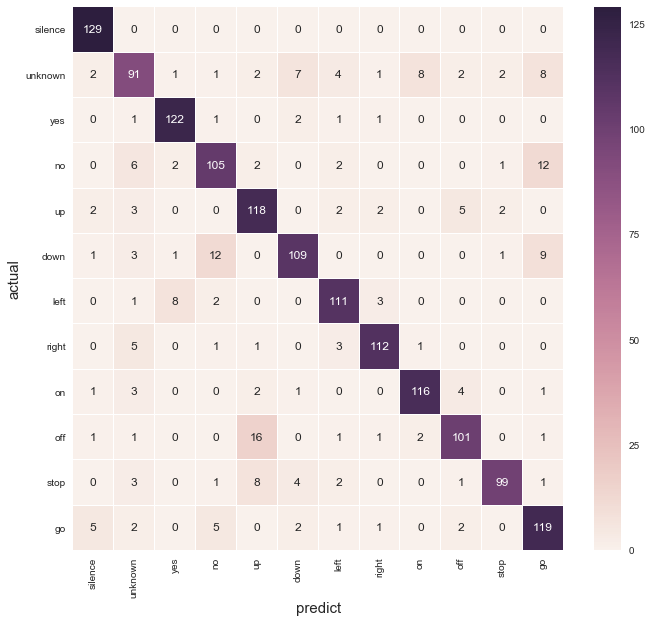

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

a =  """  [[129   0   0   0   0   0   0   0   0   0   0   0]
 [  2  91   1   1   2   7   4   1   8   2   2   8]
 [  0   1 122   1   0   2   1   1   0   0   0   0]
 [  0   6   2 105   2   0   2   0   0   0   1  12]
 [  2   3   0   0 118   0   2   2   0   5   2   0]
 [  1   3   1  12   0 109   0   0   0   0   1   9]
 [  0   1   8   2   0   0 111   3   0   0   0   0]
 [  0   5   0   1   1   0   3 112   1   0   0   0]
 [  1   3   0   0   2   1   0   0 116   4   0   1]
 [  1   1   0   0  16   0   1   1   2 101   0   1]
 [  0   3   0   1   8   4   2   0   0   1  99   1]
 [  5   2   0   5   0   2   1   1   0   2   0 119]]"""

l = eval(a.strip().replace('\n', ',').replace(' ',',').
         replace(',,',',').replace(',,',',').replace(',,',',').
         replace(',,',',').replace('[,','['))

default = 'yes,no,up,down,left,right,on,off,stop,go'.split(',')
default =  ['silence', 'unknown'] + default


array = l
df_cm = pd.DataFrame(array, index = default, columns = default)
_ = plt.figure(figsize = (11,10))
sns.heatmap(df_cm, annot=True, fmt='.0f', 
            linewidths=0.01)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('predict', size = 15)
plt.ylabel('actual', size = 15)
plt.show()

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import sys

import numpy as np
from six.moves import xrange
import tensorflow as tf

import input_data
import models
from tensorflow.python.platform import gfile

FLAGS = None

/home/dkuzin/apps/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class FLAGS:
    def __init__(self):
        self.data_dir = "/home/dkuzin/files/tensorflow_speech_recognition/train/audio"
        self.testing_percentage = 5
        self.validation_percentage = 5
        self.how_many_training_steps = "15000,25000,25000"
        self.learning_rate = "0.001,0.0001,0.00001"
        self.batch_size = 200
        self.eval_step_interval = 400
        self.train_dir = "/home/dkuzin/files/tensorflow_speech_recognition/saved_models/calc_test"
        self.save_step_interval = 400
        self.model_architecture = "conv"
        self.summaries_dir = "/home/dkuzin/files/tensorflow_speech_recognition/board"
        self.data_url = 'http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz'
        self.silence_percentage = 10.
        self.unknown_percentage = 10.
        self.wanted_words = 'yes,no,up,down,left,right,on,off,stop,go'
        self.sample_rate = 16000
        self.clip_duration_ms = 1000
        self.window_size_ms = 30.
        self.window_stride_ms = 10.
        self.dct_coefficient_count = 40
        self.data_dir = "/home/dkuzin/files/tensorflow_speech_recognition/train/audio/"
        self.background_frequency = 0.8
        self.background_volume = 0.1
        self.time_shift_ms = 100
        self.predict_dir = '/home/dkuzin/files/tensorflow_speech_recognition/test/audio'

In [3]:
FLAGS = FLAGS()

In [4]:
model_settings = models.prepare_model_settings(
      len(input_data.prepare_words_list(FLAGS.wanted_words.split(','))),
      FLAGS.sample_rate, FLAGS.clip_duration_ms, FLAGS.window_size_ms,
      FLAGS.window_stride_ms, FLAGS.dct_coefficient_count)

In [5]:
audio_processor = input_data.AudioProcessor(
      FLAGS.data_url, FLAGS.data_dir, FLAGS.silence_percentage,
      FLAGS.unknown_percentage,
      FLAGS.wanted_words.split(','), FLAGS.validation_percentage,
      FLAGS.testing_percentage, model_settings, predict_dir=FLAGS.predict_dir)

INFO:tensorflow:I ve found 158538 files for prediction


In [6]:
time_shift_samples = int((FLAGS.time_shift_ms * FLAGS.sample_rate) / 1000)

In [7]:
config = tf.ConfigProto(log_device_placement=True,
          intra_op_parallelism_threads=0, inter_op_parallelism_threads=0)
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

In [45]:
train_fingerprints, train_ground_truth = audio_processor.get_data(
        3000, 0, model_settings, FLAGS.background_frequency,
        FLAGS.background_volume, time_shift_samples, 'training', sess)

In [55]:
audio_processor.data_index['training'][0]

{'file': '/home/dkuzin/files/tensorflow_speech_recognition/train/audio/go/10ace7eb_nohash_0.wav',
 'label': 'go'}

In [12]:
audio_processor.data_index['predict']

[]

In [15]:
search_path = os.path.join(FLAGS.predict_dir, '*.wav')

In [16]:
search_path

'/home/dkuzin/files/tensorflow_speech_recognition/test/audio/*.wav'

In [7]:
audio_processor.words_list

['_silence_',
 '_unknown_',
 'yes',
 'no',
 'up',
 'down',
 'left',
 'right',
 'on',
 'off',
 'stop',
 'go']